In [1]:

import kagglehub
humansintheloop_plant_semantic_segmentation_path = kagglehub.dataset_download('humansintheloop/plant-semantic-segmentation')
print('Data source import complete.')

100%|██████████| 1.38G/1.38G [01:04<00:00, 22.8MB/s]

Extracting files...


Data source import complete.


In [1]:
!pip install -U segmentation-models-pytorch patchify

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 68.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
!pip install numpy==1.23.5 pandas==1.5.3


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 94.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 99.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 1.5.3 which is incompatible.
xarray 2025.3.1 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
xarray 2025.3.1 requires pandas>=2.1, but you have pandas 1.5.3 which is incompatible.
chex 0.1.89 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
pymc 5.22.0 r

In [2]:
import os
import shutil
import random
import cv2
from PIL import Image
from patchify import patchify, unpatchify
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import SequentialLR, CosineAnnealingLR, LinearLR
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import matplotlib.pyplot as plt

In [4]:
DEVICE= torch.device("cuda" if torch.cuda.is_available() else "cpu")
N_CLASSES= 1
print(DEVICE)

cuda


In [7]:

base_path = humansintheloop_plant_semantic_segmentation_path


imgs_dir = os.path.join(base_path, "Plant segmentation", "images")
masks_dir = os.path.join(base_path, "Plant segmentation", "masks")

print("Images path:", imgs_dir)
print("Masks path:", masks_dir)
print("Images exist:", os.path.exists(imgs_dir))
print("Masks exist:", os.path.exists(masks_dir))

# Получим список файлов
imgs_list = os.listdir(imgs_dir)
random.shuffle(imgs_list)
print("Пример файлов:", imgs_list[:5])

Images path: /root/.cache/kagglehub/datasets/humansintheloop/plant-semantic-segmentation/versions/2/Plant segmentation/images
Masks path: /root/.cache/kagglehub/datasets/humansintheloop/plant-semantic-segmentation/versions/2/Plant segmentation/masks
Images exist: True
Masks exist: True
Пример файлов: ['T02_Box051_2017-09-26T14-54-12-576.png', 'T02_Box007_2017-09-05T09-21-20-473.png', 'T02_Box029_2017-10-25T11-27-52-117.png', 'T02_Box029_2017-10-05T12-22-30-475.png', 'T02_Box007_2017-10-25T10-59-23-241.png']


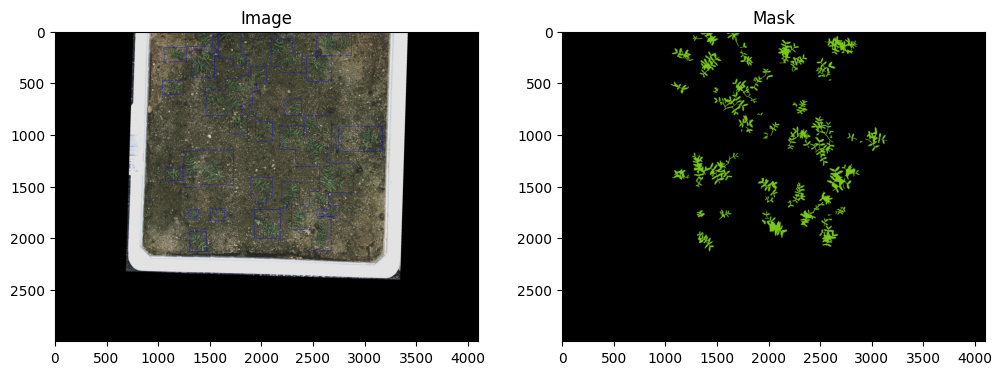

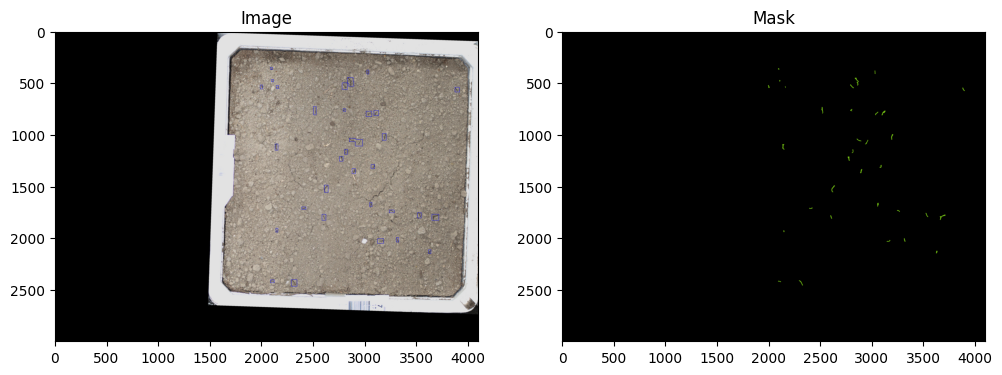

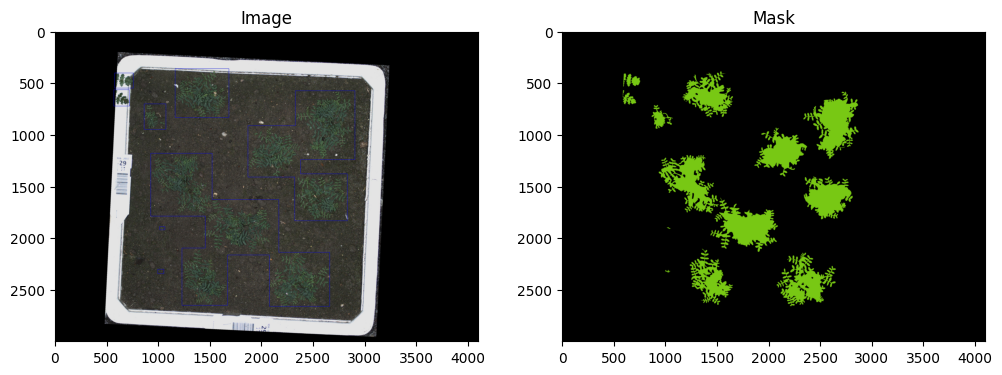

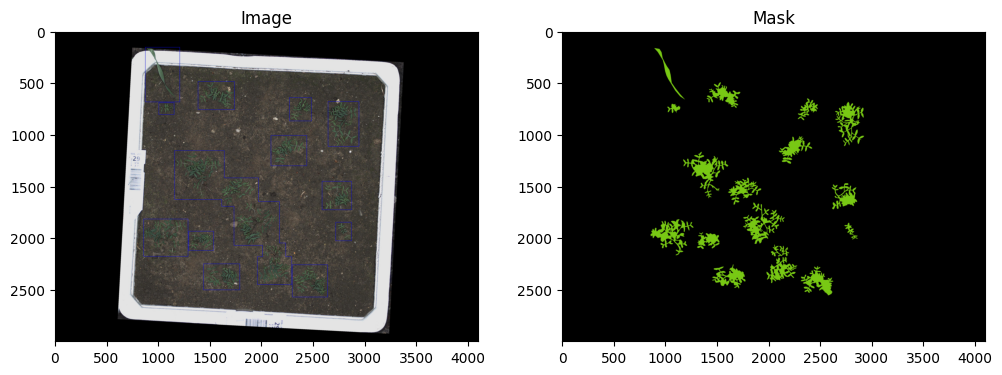

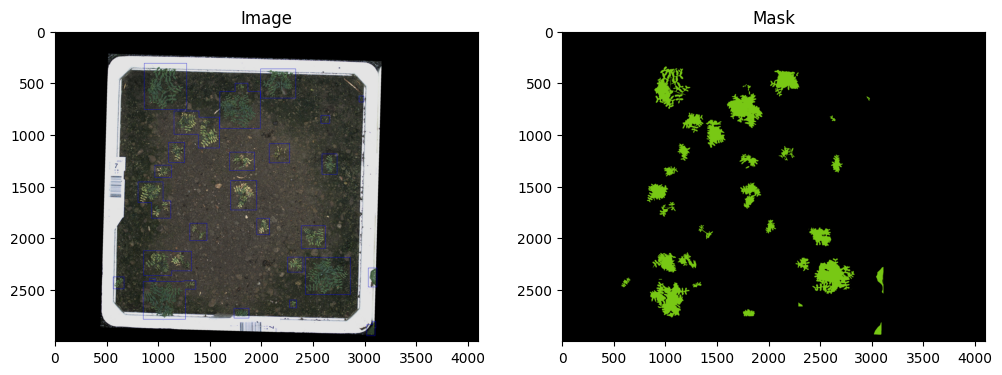

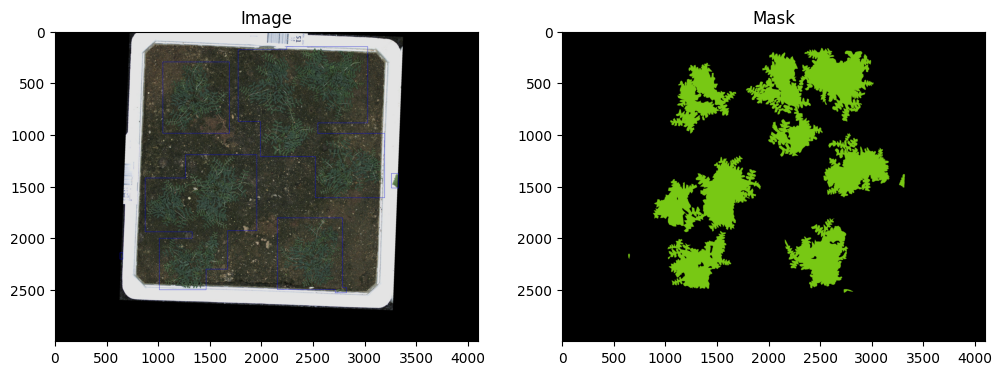

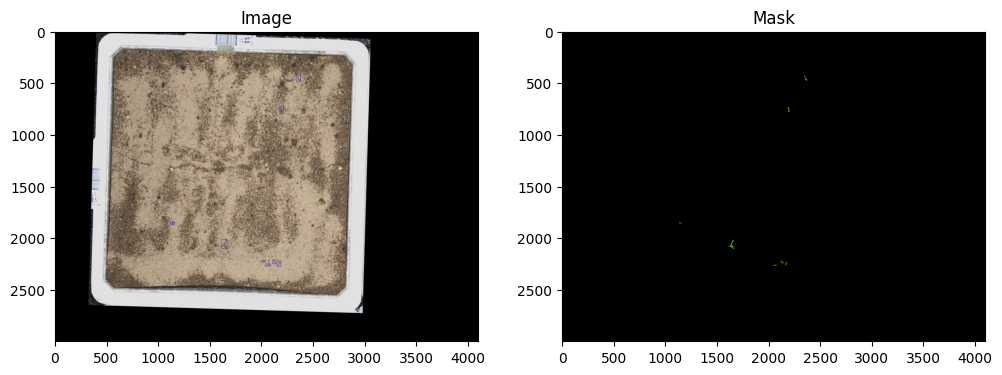

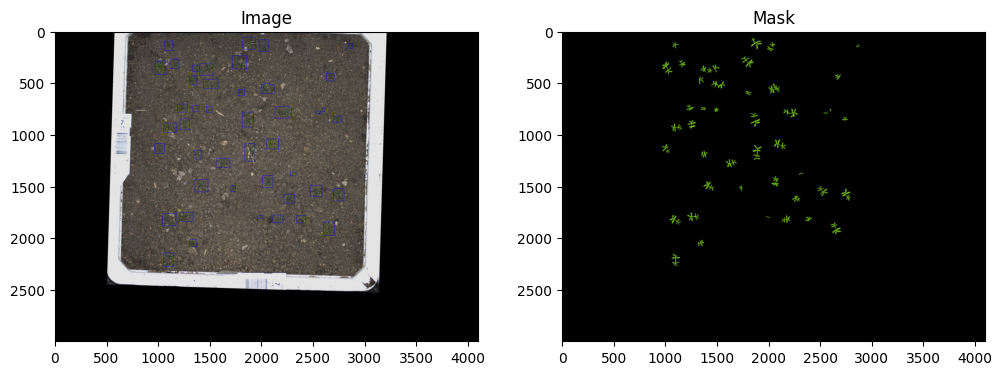

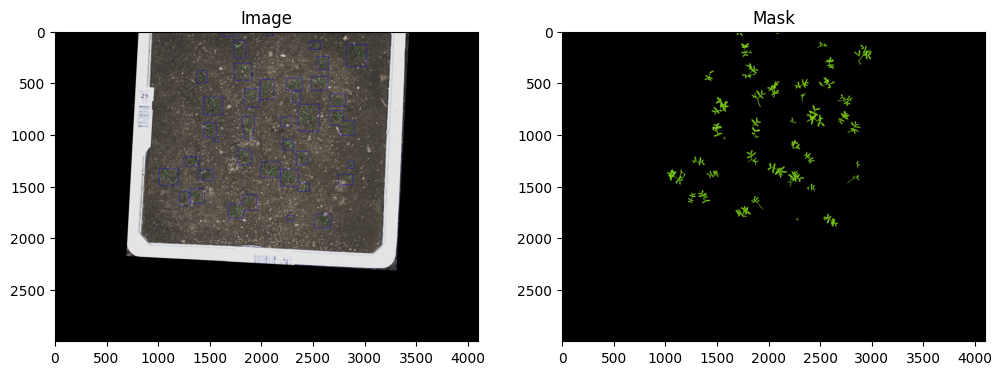

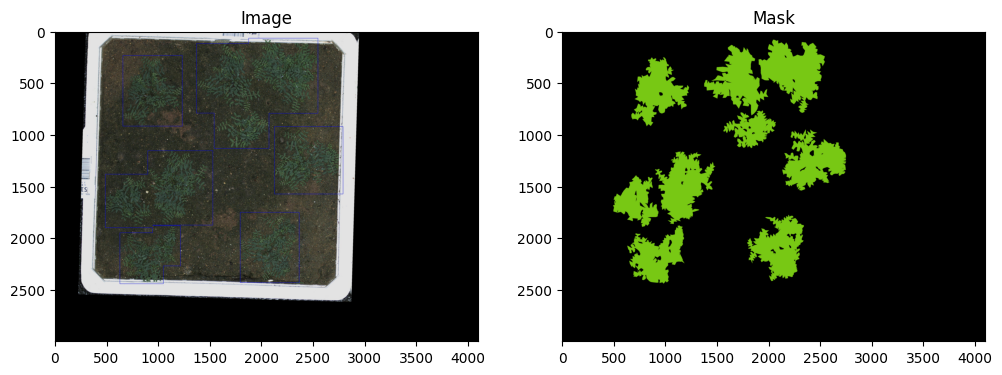

In [8]:
for file_name in imgs_list[:10]:
    img_name= file_name

    img_path= os.path.join(imgs_dir, img_name)
    mask_path= os.path.join(masks_dir, img_name)

    img= Image.open(img_path)
    mask= Image.open(mask_path)

    plt.figure(figsize= (12, 8))

    plt.subplot(121)
    plt.imshow(img)
    plt.title("Image")

    plt.subplot(122)
    plt.imshow(mask)
    plt.title("Mask")

In [9]:
# Patch settings
PATCH_SIZE = 256  # Patch size (256x256)
STRIDE = 256  # No overlap when STRIDE = PATCH_SIZE

# Store extracted patches
all_image_patches = []
all_mask_patches = []

In [11]:
import numpy as np

for filename in os.listdir(imgs_dir):
    image = Image.open(os.path.join(imgs_dir, filename)).convert('RGB')
    image= image.resize((1080, 720))
    image= np.array(image)

    mask = Image.open(os.path.join(masks_dir, filename.replace(".jpg", ".png"))).convert('L')
    mask= mask.resize((1080, 720))
    mask= np.array(mask)
    mask[mask != 0.0]= 1.0

    patches_img = patchify(image, (PATCH_SIZE, PATCH_SIZE, 3), step=STRIDE)
    patches_mask = patchify(mask, (PATCH_SIZE, PATCH_SIZE), step=STRIDE)

    patches_img = patches_img.reshape(-1, PATCH_SIZE, PATCH_SIZE, 3)
    patches_mask = patches_mask.reshape(-1, PATCH_SIZE, PATCH_SIZE)
    all_image_patches.extend(patches_img)
    all_mask_patches.extend(patches_mask)

# Convert to NumPy arrays
all_image_patches = np.array(all_image_patches)
all_mask_patches = np.array(all_mask_patches)

In [12]:
all_image_patches.shape, all_mask_patches.shape

((1152, 256, 256, 3), (1152, 256, 256))

In [13]:
np.unique(all_mask_patches)

array([0, 1], dtype=uint8)

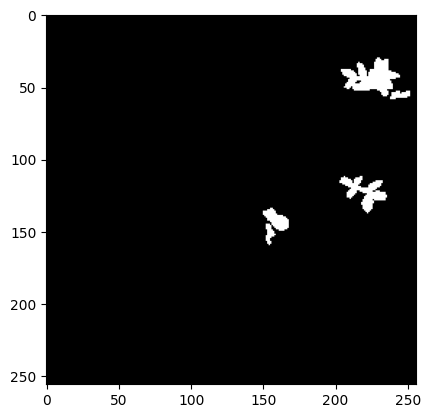

In [14]:
plt.imshow(all_mask_patches[25], cmap= 'gray')

In [15]:
class PlantDataset(Dataset):

    def __init__(self, img_patches, mask_patches, transform= None, label_encoder= None, preprocessing= None):

        self.img_patches = img_patches
        self.mask_patches = mask_patches

        self.transform = transform
        self.label_encoder = label_encoder
        self.preprocessing= preprocessing

    def __getitem__(self, img_id):


        img = np.array(Image.fromarray(self.img_patches[img_id]).convert('RGB'))
        mask = np.array(Image.fromarray(self.mask_patches[img_id]).convert('L'))

        h, w = mask.shape

        mask_encoded = self.label_encoder.transform(mask.ravel()).reshape(h, w)

        if self.transform is not None:
            augmented = self.transform(image=img, mask=mask_encoded)
            img, mask = augmented['image'], augmented['mask']
        else:
            mask = mask_encoded

        if self.preprocessing is not None:
            preprocessed= self.preprocessing(image= img)
            img= preprocessed["image"]

            img = torch.tensor(img).permute(2, 0, 1).to(torch.float32)


        else:
            img = torch.tensor(img).div(255.0).permute(2, 0, 1).to(torch.float32)

        mask = torch.tensor(mask).to(torch.long)

        return img, mask



    def __len__(self):
        return len(self.img_patches)


In [16]:
label = LabelEncoder()

unique_values = np.unique(all_mask_patches)

In [17]:
unique_values

array([0, 1], dtype=uint8)

In [18]:
label.fit(unique_values)

LabelEncoder()

In [19]:
encoder_name = "resnet34"
preprocessing_fn = smp.encoders.get_preprocessing_fn(encoder_name, pretrained="imagenet")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

In [20]:
preprocessing_fn

functools.partial(<function preprocess_input at 0x78ae6b4ee700>, input_space='RGB', input_range=[0, 1], mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [21]:
def get_preprocessing(preprocessing_fn):
    return A.Compose([
        A.Lambda(image=preprocessing_fn),
    ])

In [22]:
preprocessing = get_preprocessing(preprocessing_fn)

In [25]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transforms = A.Compose([
    A.Resize(256, 256),  # Приведение к фиксированному размеру (по выбору)
    ToTensorV2(),        # Перевод изображения и маски в PyTorch-тензоры
])


In [26]:
dataset= PlantDataset(all_image_patches, all_mask_patches, train_transforms, label, preprocessing)

In [28]:
# split the dataset -> 80% train ~ 15% val ~ 5% test
dataset_size= len(dataset)

print(dataset_size)

train_dataset_size= int(dataset_size * 0.8)
val_dataset_size= int(dataset_size * 0.15)
test_dataset_size= dataset_size - train_dataset_size - val_dataset_size

1152


In [29]:
train_dataset, val_dataset, test_dataset= random_split(dataset, [train_dataset_size, val_dataset_size, test_dataset_size])

In [30]:
len(dataset), len(train_dataset), len(val_dataset), len(test_dataset)


(1152, 921, 172, 59)

In [31]:
train_dataset.dataset.transform= train_transforms
val_dataset.dataset.transform= None
test_dataset.dataset.transform= None

# Unet + Resnet 34

In [32]:
DEVICE, N_CLASSES

(device(type='cuda'), 1)

In [33]:
# test -> in channels 1
sample= torch.randn((16, 3, 256, 256))
sample= sample.to(DEVICE)

model = smp.Unet(encoder_name="resnet34", encoder_weights="imagenet", in_channels=3, classes= N_CLASSES)
model= model.to(DEVICE)

out= model(sample)

print(sample.shape, out.shape)

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

torch.Size([16, 3, 256, 256]) torch.Size([16, 1, 256, 256])


# тренировка модели

In [34]:
X, y= train_dataset[56]

X.shape, y.shape, y.unique()

(torch.Size([3, 256, 256]), torch.Size([256, 256]), tensor([0, 1]))

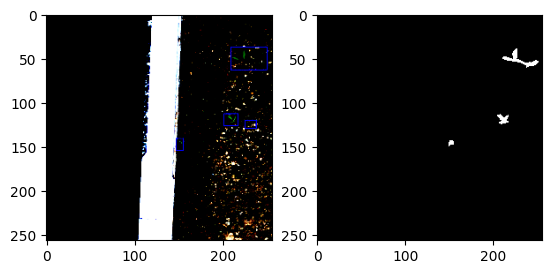

In [35]:
X= X.permute(1, 2, 0)

plt.subplot(121)
plt.imshow(X)

plt.subplot(122)
plt.imshow(y, cmap= 'gray')

In [36]:
def train_one_epoch(data_loader, epoch_num, num_epochs, model, optimizer, scaler, dice_loss_fn, bce_loss_fn):
    print(f"Running epoch [{epoch_num + 1}/{num_epochs}] \n")

    loop = tqdm(data_loader)  # Progress bar
    model.train()

    for batch_images, batch_masks in loop:
        batch_images = batch_images.to(DEVICE)  # Move images to device

        batch_masks = batch_masks.to(torch.float32).unsqueeze(1).to(DEVICE)

        with torch.amp.autocast(device_type= "cuda"):
            model_preds = model(batch_images)

            dice_loss = dice_loss_fn(model_preds, batch_masks)
            bce_loss = bce_loss_fn(model_preds, batch_masks)
            loss = dice_loss + bce_loss

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        loop.set_postfix(loss=loss.item())


In [37]:
def get_metrics(data_loader, model, dice_loss_fn, bce_loss_fn, num_classes):
    y_preds = []
    y_true = []
    total_loss = 0.0
    threshold= 0.5

    model.eval()
    with torch.no_grad():
        for batch_features, batch_labels in tqdm(data_loader):
            batch_features = batch_features.to(DEVICE)

            batch_labels = batch_labels.to(torch.float32).unsqueeze(1).to(DEVICE)

            model_preds = model(batch_features)

            dice_loss = dice_loss_fn(model_preds, batch_labels)
            bce_loss = bce_loss_fn(model_preds, batch_labels)
            loss = dice_loss + bce_loss

            model_preds= torch.sigmoid(model_preds)

            y_preds.extend(model_preds.cpu().numpy())
            y_true.extend(batch_labels.cpu().numpy())
            total_loss += loss.item()

    y_preds = np.concatenate(y_preds, axis=0)
    y_true = np.concatenate(y_true, axis=0)

    y_preds= (y_preds >= threshold).astype(np.float32)

    # Pixel accuracy
    pixel_accuracy = np.mean(y_preds == y_true)

    # Dice coefficient
    intersection = np.logical_and(y_true, y_preds).sum()
    union= np.logical_or(y_true, y_preds).sum()

    dice_coeff = (2 * intersection) / (y_true.sum() + y_preds.sum() + 1e-7)
    iou_score= intersection / (union + 1e-7)

    return (total_loss / len(data_loader)), pixel_accuracy, dice_coeff, iou_score

In [38]:
def train_model(train_dataset, val_dataset, test_dataset, model, model_save_path, num_epochs, patience_limit, learning_rate, weight_decay, batch_size, num_classes, pin_memory, optimizer_name= None):
    best_epoch = 0
    best_val_dice_coeff = 0

    train_losses= []
    val_losses= []

    train_pixel_accuracies = []
    train_dice_coeffs = []

    val_pixel_accuracies = []
    val_dice_coeffs = []

    train_ious= []
    val_ious= []

    no_improve_epochs = 0

    train_loader = DataLoader(dataset=train_dataset,
                              batch_size=batch_size,
                              pin_memory=pin_memory,
                              shuffle=True)

    val_loader = DataLoader(dataset=val_dataset,
                            batch_size=batch_size,
                            pin_memory=pin_memory,
                            shuffle=False)

    dice_loss_fn = smp.losses.DiceLoss(mode= 'binary')
    bce_loss_fn= nn.BCEWithLogitsLoss()

    if optimizer_name is None:
        optimizer = optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay= weight_decay)

    else:

        if optimizer_name == 'Adam':
            optimizer = optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay= weight_decay)

        elif optimizer_name == 'SGD':
            optimizer = optim.SGD(params=model.parameters(), lr=learning_rate, weight_decay= weight_decay)

        else:
            optimizer = optim.AdamW(params=model.parameters(), lr=learning_rate, weight_decay= weight_decay)

    scaler = torch.amp.GradScaler()

    warmup_scheduler = LinearLR(optimizer, start_factor=0.1, end_factor=1.0, total_iters=5)
    cosine_scheduler = CosineAnnealingLR(optimizer, T_max= num_epochs - 5)

    scheduler = SequentialLR(optimizer, schedulers=[warmup_scheduler, cosine_scheduler], milestones=[5])

    for i in range(num_epochs):
        train_one_epoch(data_loader=train_loader,
                        epoch_num=i,
                        num_epochs= num_epochs,
                        model=model,
                        optimizer=optimizer,
                        scaler=scaler,
                        dice_loss_fn= dice_loss_fn,
                        bce_loss_fn= bce_loss_fn)

        train_loss, train_pixel_accuracy, train_dice_coeff, train_iou = get_metrics(train_loader, model, dice_loss_fn, bce_loss_fn, num_classes)

        val_loss, val_pixel_accuracy, val_dice_coeff, val_iou = get_metrics(val_loader, model, dice_loss_fn, bce_loss_fn, num_classes)

        print(f"\n(TRAIN) Loss: {train_loss}\n(TRAIN) Pixel accuracy: {train_pixel_accuracy}\n(TRAIN) Dice coeff: {train_dice_coeff}\n(TRAIN) IoU: {train_iou}\n")
        print(f"(VAL) Loss: {val_loss}\n(VAL) Pixel accuracy: {val_pixel_accuracy}\n(VAL) Dice coeff: {val_dice_coeff}\n(VAL) IoU: {val_iou}\n")

        scheduler.step()

        train_losses.append(train_loss)
        train_pixel_accuracies.append(train_pixel_accuracy)
        train_dice_coeffs.append(train_dice_coeff)
        train_ious.append(train_iou)


        val_losses.append(val_loss)
        val_pixel_accuracies.append(val_pixel_accuracy)
        val_dice_coeffs.append(val_dice_coeff)
        val_ious.append(val_iou)


        if val_dice_coeff > best_val_dice_coeff:
            best_val_dice_coeff = val_dice_coeff
            best_epoch = i

            torch.save(model.state_dict(), model_save_path)

            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= patience_limit:
                print(f"\n\nEarly stopping at epoch {i}...\nSaved the best weights from epoch {best_epoch} with a validation Dice coeff: {best_val_dice_coeff}")
                break

    print(f"\nSaved the best weights at path: ~ {model_save_path} ~")

    return train_losses, train_pixel_accuracies, train_dice_coeffs, train_ious, val_losses, val_pixel_accuracies, val_dice_coeffs, val_ious


In [39]:
DEVICE, N_CLASSES


(device(type='cuda'), 1)

In [42]:
# Define training hyperparameters
NUM_EPOCHS = 20          # Number of training epochs
LEARNING_RATE = 3e-5     # Initial learning rate
WEIGHT_DECAY = 1e-5      # Weight decay for regularization
BATCH_SIZE = 8          # Batch size for data loaders
PIN_MEMORY = True        # Enable pinned memory for faster data transfer to GPU
PATIENCE_LIMIT= 7


model = smp.Unet(encoder_name="resnet34", encoder_weights="imagenet", in_channels=3, classes= N_CLASSES)
model= model.to(DEVICE)

# сохарнить
model_save_path = "best_weights.pth"


In [ ]:
train_losses, train_pixel_accuracies, train_dice_coeffs, train_ious, val_losses, val_pixel_accuracies, val_dice_coeffs, val_ious = train_model(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,

    model=model,                    # UNet model instance
    model_save_path=model_save_path,

    num_epochs=NUM_EPOCHS,
    patience_limit= PATIENCE_LIMIT,

    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,

    batch_size=BATCH_SIZE,
    num_classes= N_CLASSES,
    pin_memory=PIN_MEMORY
)

Running epoch [1/20] 



100%|██████████| 22/22 [00:01<00:00, 11.88it/s]



(TRAIN) Loss: 1.9160385203772579
(TRAIN) Pixel accuracy: 0.2799171505740618
(TRAIN) Dice coeff: 0.12043722944739146
(TRAIN) IoU: 0.06407727640130746

(VAL) Loss: 1.9127079085870222
(VAL) Pixel accuracy: 0.2734437099722929
(VAL) Dice coeff: 0.1544638242613928
(VAL) IoU: 0.08369590707132815

Running epoch [2/20] 



100%|██████████| 22/22 [00:01<00:00, 15.83it/s]



(TRAIN) Loss: 1.6059985058061008
(TRAIN) Pixel accuracy: 0.5172683599846889
(TRAIN) Dice coeff: 0.16769094604519869
(TRAIN) IoU: 0.09151870045384698

(VAL) Loss: 1.5837102640758862
(VAL) Pixel accuracy: 0.48993044121320856
(VAL) Dice coeff: 0.20531186964774767
(VAL) IoU: 0.11439974788680977

Running epoch [3/20] 



100%|██████████| 22/22 [00:01<00:00, 15.79it/s]



(TRAIN) Loss: 1.4358995957621212
(TRAIN) Pixel accuracy: 0.6898384218495521
(TRAIN) Dice coeff: 0.24428714305644084
(TRAIN) IoU: 0.13913839879378653

(VAL) Loss: 1.4235697984695435
(VAL) Pixel accuracy: 0.6705524533293968
(VAL) Dice coeff: 0.29102327124688687
(VAL) IoU: 0.17029095033916605

Running epoch [4/20] 



100%|██████████| 22/22 [00:01<00:00, 15.63it/s]



(TRAIN) Loss: 1.331683888517577
(TRAIN) Pixel accuracy: 0.7852432135003139
(TRAIN) Dice coeff: 0.3225612543813587
(TRAIN) IoU: 0.19229389754150591

(VAL) Loss: 1.3099271763454785
(VAL) Pixel accuracy: 0.7762166400288426
(VAL) Dice coeff: 0.38012886782237704
(VAL) IoU: 0.23466611650234345

Running epoch [5/20] 



100%|██████████| 22/22 [00:01<00:00, 15.63it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



(TRAIN) Loss: 1.2424117321598118
(TRAIN) Pixel accuracy: 0.8671495269874796
(TRAIN) Dice coeff: 0.43023617696688066
(TRAIN) IoU: 0.2740770112382717

(VAL) Loss: 1.2115403088656338
(VAL) Pixel accuracy: 0.8635171402332394
(VAL) Dice coeff: 0.4971871508041942
(VAL) IoU: 0.33083770282524

Running epoch [6/20] 



100%|██████████| 22/22 [00:01<00:00, 15.80it/s]



(TRAIN) Loss: 1.110672912207143
(TRAIN) Pixel accuracy: 0.9613830367594666
(TRAIN) Dice coeff: 0.719406200523122
(TRAIN) IoU: 0.5617754832305132

(VAL) Loss: 1.0734148242256858
(VAL) Pixel accuracy: 0.9548763896143714
(VAL) Dice coeff: 0.7478197580736752
(VAL) IoU: 0.5972141493969325

Running epoch [7/20] 



100%|██████████| 22/22 [00:01<00:00, 15.50it/s]



(TRAIN) Loss: 1.0547622694023724
(TRAIN) Pixel accuracy: 0.971450109823519
(TRAIN) Dice coeff: 0.7780966304221894
(TRAIN) IoU: 0.6367906413835618

(VAL) Loss: 1.0078245536847548
(VAL) Pixel accuracy: 0.9657557287881541
(VAL) Dice coeff: 0.7975728119699744
(VAL) IoU: 0.6633023769835604

Running epoch [8/20] 



100%|██████████| 22/22 [00:01<00:00, 13.49it/s]



(TRAIN) Loss: 0.9921555817127228
(TRAIN) Pixel accuracy: 0.9731128870728997
(TRAIN) Dice coeff: 0.7893505376209996
(TRAIN) IoU: 0.6520058548325602

(VAL) Loss: 0.9407853240316565
(VAL) Pixel accuracy: 0.9683289638785428
(VAL) Dice coeff: 0.8104424895292198
(VAL) IoU: 0.681297442448561

Running epoch [9/20] 



100%|██████████| 22/22 [00:01<00:00, 15.70it/s]



(TRAIN) Loss: 0.8989916942242918
(TRAIN) Pixel accuracy: 0.9815275542251968
(TRAIN) Dice coeff: 0.8380645335574901
(TRAIN) IoU: 0.7212659891718312

(VAL) Loss: 0.8444610102610155
(VAL) Pixel accuracy: 0.9778153175531432
(VAL) Dice coeff: 0.8535891644154484
(VAL) IoU: 0.7445752760878308

Running epoch [10/20] 



100%|██████████| 22/22 [00:01<00:00, 15.82it/s]



(TRAIN) Loss: 0.8871059957249411
(TRAIN) Pixel accuracy: 0.9774467145192896
(TRAIN) Dice coeff: 0.816569275219514
(TRAIN) IoU: 0.6900017534790462

(VAL) Loss: 0.8416897085579959
(VAL) Pixel accuracy: 0.9730350583098656
(VAL) Dice coeff: 0.8334688430030532
(VAL) IoU: 0.7144848536653656

Running epoch [11/20] 



100%|██████████| 22/22 [00:01<00:00, 15.72it/s]



(TRAIN) Loss: 0.8305827800569863
(TRAIN) Pixel accuracy: 0.9795750090923164
(TRAIN) Dice coeff: 0.8298441838821373
(TRAIN) IoU: 0.7091740881443025

(VAL) Loss: 0.7779614166779951
(VAL) Pixel accuracy: 0.9755357254383176
(VAL) Dice coeff: 0.8455422985108596
(VAL) IoU: 0.7324151395241164

Running epoch [12/20] 



100%|██████████| 22/22 [00:01<00:00, 15.72it/s]



(TRAIN) Loss: 0.7876856448449965
(TRAIN) Pixel accuracy: 0.9782385976255005
(TRAIN) Dice coeff: 0.8208629880194616
(TRAIN) IoU: 0.6961557305717156

(VAL) Loss: 0.746662589636716
(VAL) Pixel accuracy: 0.9739654895871185
(VAL) Dice coeff: 0.8377010721265428
(VAL) IoU: 0.7207277336641797

Running epoch [13/20] 



100%|██████████| 22/22 [00:01<00:00, 12.81it/s]



(TRAIN) Loss: 0.7576218465792721
(TRAIN) Pixel accuracy: 0.9831669545458401
(TRAIN) Dice coeff: 0.8502383315699218
(TRAIN) IoU: 0.7394909353091103

(VAL) Loss: 0.7058549983934923
(VAL) Pixel accuracy: 0.9793718027514081
(VAL) Dice coeff: 0.8618549841224065
(VAL) IoU: 0.7572453176872657

Running epoch [14/20] 



100%|██████████| 22/22 [00:01<00:00, 15.61it/s]



(TRAIN) Loss: 0.7268084195153467
(TRAIN) Pixel accuracy: 0.981993071548843
(TRAIN) Dice coeff: 0.8453852459086236
(TRAIN) IoU: 0.7321794935609488

(VAL) Loss: 0.6782305687665939
(VAL) Pixel accuracy: 0.9779508723769077
(VAL) Dice coeff: 0.8571569789294241
(VAL) IoU: 0.7500216242528821

Running epoch [15/20] 



100%|██████████| 22/22 [00:01<00:00, 15.64it/s]



(TRAIN) Loss: 0.7135336767753651
(TRAIN) Pixel accuracy: 0.9822054851585827
(TRAIN) Dice coeff: 0.8481004942430121
(TRAIN) IoU: 0.7362625732577862

(VAL) Loss: 0.6690950962630186
(VAL) Pixel accuracy: 0.9782878964446312
(VAL) Dice coeff: 0.8600568937173406
(VAL) IoU: 0.7544735250182578

Running epoch [16/20] 



100%|██████████| 22/22 [00:01<00:00, 15.69it/s]



(TRAIN) Loss: 0.7053463389647419
(TRAIN) Pixel accuracy: 0.9811840243758907
(TRAIN) Dice coeff: 0.8416675205721398
(TRAIN) IoU: 0.7266199778735963

(VAL) Loss: 0.6608081012964249
(VAL) Pixel accuracy: 0.9773273024448129
(VAL) Dice coeff: 0.8554460216843776
(VAL) IoU: 0.7474055727308647

Running epoch [17/20] 



100%|██████████| 22/22 [00:01<00:00, 15.72it/s]



(TRAIN) Loss: 0.6910020912644165
(TRAIN) Pixel accuracy: 0.9823343979030945
(TRAIN) Dice coeff: 0.8491868350213567
(TRAIN) IoU: 0.7379015646185415

(VAL) Loss: 0.6489946489984338
(VAL) Pixel accuracy: 0.978312470192133
(VAL) Dice coeff: 0.8602295869652475
(VAL) IoU: 0.7547393555117827

Running epoch [18/20] 



100%|██████████| 22/22 [00:01<00:00, 12.78it/s]



(TRAIN) Loss: 0.6908485220167143
(TRAIN) Pixel accuracy: 0.98228381692263
(TRAIN) Dice coeff: 0.8488795684667684
(TRAIN) IoU: 0.7374376696069113

(VAL) Loss: 0.6456364379687742
(VAL) Pixel accuracy: 0.9785048906193223
(VAL) Dice coeff: 0.8612393773504777
(VAL) IoU: 0.7562953620108993

Running epoch [19/20] 



100%|██████████| 22/22 [00:01<00:00, 15.57it/s]



(TRAIN) Loss: 0.6887654752053064
(TRAIN) Pixel accuracy: 0.9828611491945745
(TRAIN) Dice coeff: 0.8511722324208175
(TRAIN) IoU: 0.7409049958936954

(VAL) Loss: 0.6389774978160858
(VAL) Pixel accuracy: 0.9791628815406976
(VAL) Dice coeff: 0.8634040583323721
(VAL) IoU: 0.7596402790824456

Running epoch [20/20] 



 10%|█         | 12/116 [00:01<00:12,  8.27it/s, loss=0.82]

In [46]:
## tf,ysq rjkf, ckj[]

## графики

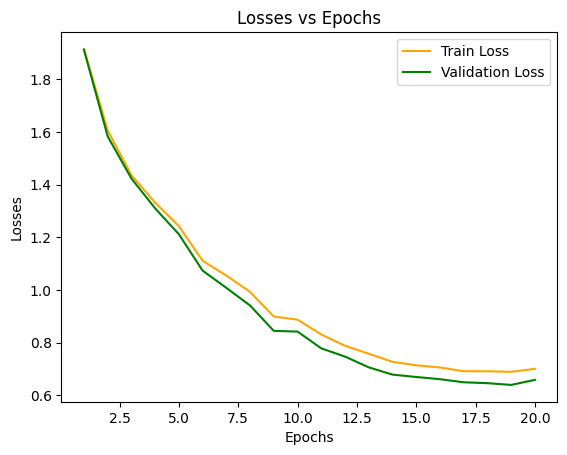

In [44]:
# plot the losses vs epochs
plt.plot(range(1, len(train_losses) + 1), train_losses, color= 'orange', label= 'Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, color= 'green', label= 'Validation Loss')

plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Losses vs Epochs")
plt.legend();

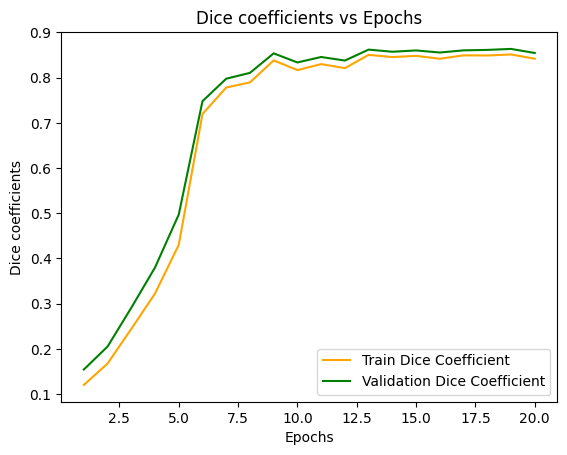

In [48]:
plt.plot(range(1, len(train_dice_coeffs) + 1), train_dice_coeffs, color= 'orange', label= 'Train Dice Coefficient')
plt.plot(range(1, len(val_dice_coeffs) + 1), val_dice_coeffs, color= 'green', label= 'Validation Dice Coefficient')
plt.xlabel("Epochs")
plt.ylabel("Dice coefficients")
plt.title("Dice coefficients vs Epochs")
plt.legend();

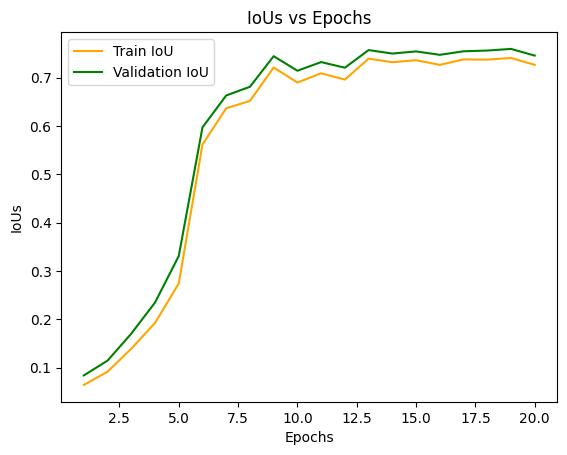

In [49]:
plt.plot(range(1, len(train_ious) + 1), train_ious, color= 'orange', label= 'Train IoU')
plt.plot(range(1, len(val_ious) + 1), val_ious, color= 'green', label= 'Validation IoU')
plt.xlabel("Epochs")
plt.ylabel("IoUs")
plt.title("IoUs vs Epochs")
plt.legend();

# тестирование

In [51]:
dice_loss_fn = smp.losses.DiceLoss(mode= 'binary')
bce_loss_fn= nn.BCEWithLogitsLoss()

test_loader = DataLoader(dataset=test_dataset, batch_size= BATCH_SIZE, pin_memory= PIN_MEMORY, shuffle=False)

In [52]:
model = smp.Unet(encoder_name="resnet34", encoder_weights="imagenet", in_channels=3, classes= N_CLASSES)
model.load_state_dict(torch.load(model_save_path))  # Load saved weights

model= model.to(DEVICE)

In [53]:
test_loss, test_pixel_accuracy, test_dice_coeff, test_iou= get_metrics(test_loader, model, dice_loss_fn, bce_loss_fn, N_CLASSES)

print(f"\n(TEST) Loss: {test_loss}\n(TEST) Pixel accuracy: {test_pixel_accuracy}\n(TEST) Dice coeff: {test_dice_coeff}\n(TEST) IoU: {test_iou}\n")

100%|██████████| 8/8 [00:01<00:00,  5.65it/s]


(TEST) Loss: 0.6663082391023636
(TEST) Pixel accuracy: 0.9816770391949152
(TEST) Dice coeff: 0.8398423018146052
(TEST) IoU: 0.723903572012843



In [54]:
## улучшение бейзлана

In [56]:
train_transforms_aug = A.Compose([
    A.Rotate(limit=30, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
])

In [57]:
dataset= PlantDataset(all_image_patches, all_mask_patches, train_transforms_aug, label, preprocessing)

In [58]:
train_losses, train_pixel_accuracies, train_dice_coeffs, train_ious, val_losses, val_pixel_accuracies, val_dice_coeffs, val_ious = train_model(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,

    model=model,                    # UNet model instance
    model_save_path=model_save_path,

    num_epochs=NUM_EPOCHS,
    patience_limit= PATIENCE_LIMIT,

    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,

    batch_size=BATCH_SIZE,
    num_classes= N_CLASSES,
    pin_memory=PIN_MEMORY
)

Running epoch [1/20] 



100%|██████████| 22/22 [00:01<00:00, 15.56it/s]



(TRAIN) Loss: 0.6819800392820917
(TRAIN) Pixel accuracy: 0.983414657211718
(TRAIN) Dice coeff: 0.8540395098456636
(TRAIN) IoU: 0.7452608682264802

(VAL) Loss: 0.6344076720151034
(VAL) Pixel accuracy: 0.9795865790788517
(VAL) Dice coeff: 0.864631806089706
(VAL) IoU: 0.7615430930047886

Running epoch [2/20] 



100%|██████████| 22/22 [00:01<00:00, 15.53it/s]



(TRAIN) Loss: 0.6942355740686943
(TRAIN) Pixel accuracy: 0.9823006827719954
(TRAIN) Dice coeff: 0.8494347886935352
(TRAIN) IoU: 0.7382760927813933

(VAL) Loss: 0.6376879675821825
(VAL) Pixel accuracy: 0.9784898092580396
(VAL) Dice coeff: 0.8612442108069784
(VAL) IoU: 0.7563028166182131

Running epoch [3/20] 



100%|██████████| 22/22 [00:01<00:00, 15.58it/s]



(TRAIN) Loss: 0.6630033264900076
(TRAIN) Pixel accuracy: 0.983846575377689
(TRAIN) Dice coeff: 0.859040494165487
(TRAIN) IoU: 0.7529105895280421

(VAL) Loss: 0.6068758002736352
(VAL) Pixel accuracy: 0.9799596209858739
(VAL) Dice coeff: 0.8681395333904478
(VAL) IoU: 0.7670022577879487

Running epoch [4/20] 



100%|██████████| 22/22 [00:02<00:00, 10.36it/s]



(TRAIN) Loss: 0.6280825090562475
(TRAIN) Pixel accuracy: 0.9850635507854913
(TRAIN) Dice coeff: 0.8673965993998813
(TRAIN) IoU: 0.7658431883042948

(VAL) Loss: 0.5765857019207694
(VAL) Pixel accuracy: 0.9815365103788154
(VAL) Dice coeff: 0.8762136326543687
(VAL) IoU: 0.7796976882038298

Running epoch [5/20] 



100%|██████████| 22/22 [00:01<00:00, 12.99it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



(TRAIN) Loss: 0.5945887521936976
(TRAIN) Pixel accuracy: 0.9853164391201819
(TRAIN) Dice coeff: 0.8701594366172295
(TRAIN) IoU: 0.7701612641804527

(VAL) Loss: 0.5426723144271157
(VAL) Pixel accuracy: 0.9818506462629452
(VAL) Dice coeff: 0.8782115734812015
(VAL) IoU: 0.7828673863274918

Running epoch [6/20] 



100%|██████████| 22/22 [00:01<00:00, 15.50it/s]



(TRAIN) Loss: 0.5351024135176478
(TRAIN) Pixel accuracy: 0.9864265035987547
(TRAIN) Dice coeff: 0.8775844963093435
(TRAIN) IoU: 0.781871324321274

(VAL) Loss: 0.49819833582097833
(VAL) Pixel accuracy: 0.9829374801280887
(VAL) Dice coeff: 0.8842041761440756
(VAL) IoU: 0.7924426290541909

Running epoch [7/20] 



100%|██████████| 22/22 [00:01<00:00, 15.58it/s]



(TRAIN) Loss: 0.5025537576654862
(TRAIN) Pixel accuracy: 0.9861859747175284
(TRAIN) Dice coeff: 0.8775222416151854
(TRAIN) IoU: 0.7817724984394282

(VAL) Loss: 0.4611665281382474
(VAL) Pixel accuracy: 0.9824374886446221
(VAL) Dice coeff: 0.8826841001778464
(VAL) IoU: 0.7900040626991396

Running epoch [8/20] 



100%|██████████| 22/22 [00:01<00:00, 15.48it/s]



(TRAIN) Loss: 0.46827993545167407
(TRAIN) Pixel accuracy: 0.9857461206558343
(TRAIN) Dice coeff: 0.8755530425421887
(TRAIN) IoU: 0.7786521513844187

(VAL) Loss: 0.4339816231619228
(VAL) Pixel accuracy: 0.9820647128792697
(VAL) Dice coeff: 0.8819260474047395
(VAL) IoU: 0.7887904421327612

Running epoch [9/20] 



100%|██████████| 22/22 [00:01<00:00, 15.73it/s]



(TRAIN) Loss: 0.438027109115802
(TRAIN) Pixel accuracy: 0.9870930194336998
(TRAIN) Dice coeff: 0.8849428235034054
(TRAIN) IoU: 0.7936299968794541

(VAL) Loss: 0.40188873356038873
(VAL) Pixel accuracy: 0.9836147219635719
(VAL) Dice coeff: 0.8894878931987416
(VAL) IoU: 0.8009709104035257

Running epoch [10/20] 



100%|██████████| 22/22 [00:01<00:00, 15.51it/s]



(TRAIN) Loss: 0.42354190940486974
(TRAIN) Pixel accuracy: 0.9866451466381226
(TRAIN) Dice coeff: 0.88268163417084
(TRAIN) IoU: 0.7900001120234011

(VAL) Loss: 0.3817118460481817
(VAL) Pixel accuracy: 0.9826991946198219
(VAL) Dice coeff: 0.8857111043390091
(VAL) IoU: 0.7948666703831858

Running epoch [11/20] 



100%|██████████| 22/22 [00:01<00:00, 12.90it/s]



(TRAIN) Loss: 0.39257154565561436
(TRAIN) Pixel accuracy: 0.9888325379544568
(TRAIN) Dice coeff: 0.8960021205259026
(TRAIN) IoU: 0.8115976825541764

(VAL) Loss: 0.36128793250430713
(VAL) Pixel accuracy: 0.9850039814793786
(VAL) Dice coeff: 0.8947323190051455
(VAL) IoU: 0.8095164043879347

Running epoch [12/20] 



100%|██████████| 22/22 [00:01<00:00, 14.99it/s]



(TRAIN) Loss: 0.3639535449027758
(TRAIN) Pixel accuracy: 0.987815484161874
(TRAIN) Dice coeff: 0.8915094583165831
(TRAIN) IoU: 0.8042553587896979

(VAL) Loss: 0.34060588614507153
(VAL) Pixel accuracy: 0.9839197203170421
(VAL) Dice coeff: 0.892298697316862
(VAL) IoU: 0.8055408937007517

Running epoch [13/20] 



100%|██████████| 22/22 [00:01<00:00, 15.02it/s]



(TRAIN) Loss: 0.35578276461054537
(TRAIN) Pixel accuracy: 0.9894780294644069
(TRAIN) Dice coeff: 0.9016386638177364
(TRAIN) IoU: 0.8208943943271844

(VAL) Loss: 0.3265181190588258
(VAL) Pixel accuracy: 0.9855812427609466
(VAL) Dice coeff: 0.8989380256940143
(VAL) IoU: 0.8164281817657238

Running epoch [14/20] 



100%|██████████| 22/22 [00:01<00:00, 15.64it/s]



(TRAIN) Loss: 0.33785463920955
(TRAIN) Pixel accuracy: 0.9889248030970074
(TRAIN) Dice coeff: 0.8995392973804016
(TRAIN) IoU: 0.8174206450435602

(VAL) Loss: 0.32426428320732986
(VAL) Pixel accuracy: 0.9849181064339572
(VAL) Dice coeff: 0.897071110454488
(VAL) IoU: 0.8133535343553718

Running epoch [15/20] 



100%|██████████| 22/22 [00:01<00:00, 15.52it/s]



(TRAIN) Loss: 0.32339149816282864
(TRAIN) Pixel accuracy: 0.9893030752705958
(TRAIN) Dice coeff: 0.9024484435615281
(TRAIN) IoU: 0.8222378605064815

(VAL) Loss: 0.3105532533743165
(VAL) Pixel accuracy: 0.9852008376010629
(VAL) Dice coeff: 0.8985370440540601
(VAL) IoU: 0.8157669208969389

Running epoch [16/20] 



100%|██████████| 22/22 [00:01<00:00, 15.50it/s]



(TRAIN) Loss: 0.3186967412716356
(TRAIN) Pixel accuracy: 0.9897502687932614
(TRAIN) Dice coeff: 0.9042546968065259
(TRAIN) IoU: 0.8252416817769037

(VAL) Loss: 0.3026722263206135
(VAL) Pixel accuracy: 0.9854935934377271
(VAL) Dice coeff: 0.8980724530267782
(VAL) IoU: 0.815001363287093

Running epoch [17/20] 



100%|██████████| 22/22 [00:01<00:00, 12.85it/s]



(TRAIN) Loss: 0.3136078102578377
(TRAIN) Pixel accuracy: 0.9894479592123456
(TRAIN) Dice coeff: 0.9036720815298064
(TRAIN) IoU: 0.8242717040270052

(VAL) Loss: 0.3020368204875426
(VAL) Pixel accuracy: 0.9852466139682504
(VAL) Dice coeff: 0.8989151966680364
(VAL) IoU: 0.8163905213729704

Running epoch [18/20] 



100%|██████████| 22/22 [00:01<00:00, 15.62it/s]



(TRAIN) Loss: 0.3275238619796161
(TRAIN) Pixel accuracy: 0.9894404706426863
(TRAIN) Dice coeff: 0.9034020459653225
(TRAIN) IoU: 0.8238224799175162

(VAL) Loss: 0.30819166654890234
(VAL) Pixel accuracy: 0.985328940458076
(VAL) Dice coeff: 0.8990180555410832
(VAL) IoU: 0.8165602170550672

Running epoch [19/20] 



100%|██████████| 22/22 [00:01<00:00, 15.48it/s]



(TRAIN) Loss: 0.3165842963960664
(TRAIN) Pixel accuracy: 0.9899415089693183
(TRAIN) Dice coeff: 0.9057694752246949
(TRAIN) IoU: 0.8277684223904191

(VAL) Loss: 0.2988265326077288
(VAL) Pixel accuracy: 0.9856966595317043
(VAL) Dice coeff: 0.8993097883650192
(VAL) IoU: 0.8170416878961534

Running epoch [20/20] 



100%|██████████| 22/22 [00:01<00:00, 15.30it/s]



(TRAIN) Loss: 0.3142151037423775
(TRAIN) Pixel accuracy: 0.989738124719013
(TRAIN) Dice coeff: 0.9056391239177527
(TRAIN) IoU: 0.827550713581695

(VAL) Loss: 0.29877949302846735
(VAL) Pixel accuracy: 0.9855359099632086
(VAL) Dice coeff: 0.9001513878443339
(VAL) IoU: 0.8184320804661175


Saved the best weights at path: ~ best_weights.pth ~


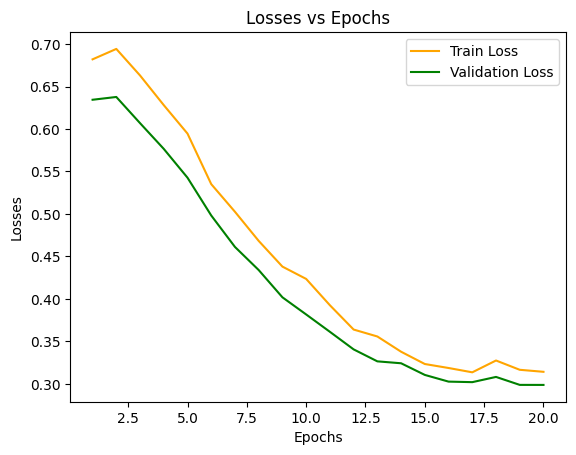

In [59]:
# plot the losses vs epochs
plt.plot(range(1, len(train_losses) + 1), train_losses, color= 'orange', label= 'Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, color= 'green', label= 'Validation Loss')

plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Losses vs Epochs")
plt.legend();

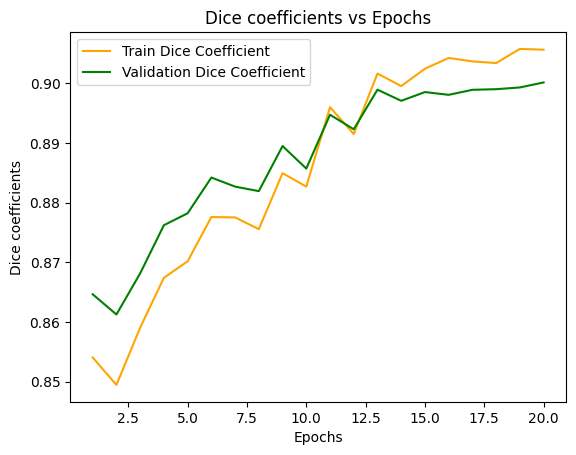

In [60]:
plt.plot(range(1, len(train_dice_coeffs) + 1), train_dice_coeffs, color= 'orange', label= 'Train Dice Coefficient')
plt.plot(range(1, len(val_dice_coeffs) + 1), val_dice_coeffs, color= 'green', label= 'Validation Dice Coefficient')
plt.xlabel("Epochs")
plt.ylabel("Dice coefficients")
plt.title("Dice coefficients vs Epochs")
plt.legend();

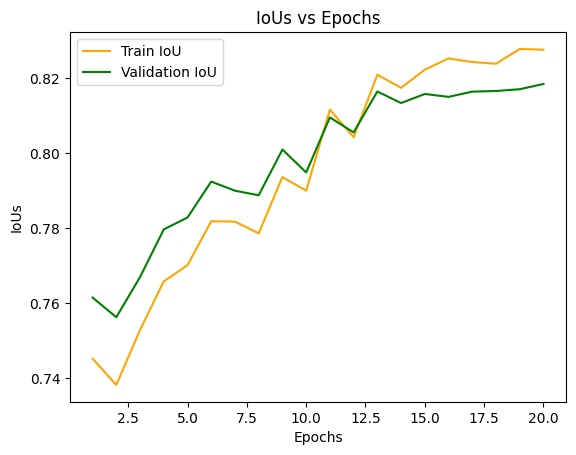

In [61]:
plt.plot(range(1, len(train_ious) + 1), train_ious, color= 'orange', label= 'Train IoU')
plt.plot(range(1, len(val_ious) + 1), val_ious, color= 'green', label= 'Validation IoU')
plt.xlabel("Epochs")
plt.ylabel("IoUs")
plt.title("IoUs vs Epochs")
plt.legend();

In [64]:
dice_loss_fn = smp.losses.DiceLoss(mode= 'binary')
bce_loss_fn= nn.BCEWithLogitsLoss()

test_loader = DataLoader(dataset=test_dataset, batch_size= BATCH_SIZE, pin_memory= PIN_MEMORY, shuffle=False)


model = smp.Unet(encoder_name="resnet34", encoder_weights="imagenet", in_channels=3, classes= N_CLASSES)
model.load_state_dict(torch.load(model_save_path))  # Load saved weights

model= model.to(DEVICE)


test_loss, test_pixel_accuracy, test_dice_coeff, test_iou= get_metrics(test_loader, model, dice_loss_fn, bce_loss_fn, N_CLASSES)

print(f"\n(TEST) Loss: {test_loss}\n(TEST) Pixel accuracy: {test_pixel_accuracy}\n(TEST) Dice coeff: {test_dice_coeff}\n(TEST) IoU: {test_iou}\n")

100%|██████████| 8/8 [00:00<00:00, 13.56it/s]


(TEST) Loss: 0.3054598644375801
(TEST) Pixel accuracy: 0.9877898652674788
(TEST) Dice coeff: 0.8864714086469277
(TEST) IoU: 0.7960921843683937



In [65]:
### Собственная имплементация

In [66]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)


class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()

        # Downsampling path
        self.down1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.down2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.down3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.down4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = DoubleConv(512, 1024)

        # Upsampling path
        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = DoubleConv(1024, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(128, 64)

        # Final output layer
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.down1(x)
        x2 = self.down2(self.pool1(x1))
        x3 = self.down3(self.pool2(x2))
        x4 = self.down4(self.pool3(x3))

        # Bottleneck
        x5 = self.bottleneck(self.pool4(x4))

        # Decoder + skip connections
        x = self.up4(x5)
        x = self.dec4(torch.cat([x, x4], dim=1))

        x = self.up3(x)
        x = self.dec3(torch.cat([x, x3], dim=1))

        x = self.up2(x)
        x = self.dec2(torch.cat([x, x2], dim=1))

        x = self.up1(x)
        x = self.dec1(torch.cat([x, x1], dim=1))

        return self.final_conv(x)


In [67]:
model = UNet(in_channels=3, out_channels=1).to(DEVICE)


In [71]:
train_transforms = A.Compose([
    A.Resize(256, 256),  # Приведение к фиксированному размеру (по выбору)
    ToTensorV2(),        # Перевод изображения и маски в PyTorch-тензоры
])

dataset= PlantDataset(all_image_patches, all_mask_patches, train_transforms, label, preprocessing)

# split the dataset -> 80% train ~ 15% val ~ 5% test
dataset_size= len(dataset)

print(dataset_size)

train_dataset_size= int(dataset_size * 0.8)
val_dataset_size= int(dataset_size * 0.15)
test_dataset_size= dataset_size - train_dataset_size - val_dataset_size


1152


In [72]:
results = train_model(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    model=model,
    model_save_path="unet_custom.pth",
    num_epochs=NUM_EPOCHS,
    patience_limit=PATIENCE_LIMIT,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    batch_size=BATCH_SIZE,
    num_classes=1,
    pin_memory=PIN_MEMORY
)

Running epoch [1/20] 



100%|██████████| 22/22 [00:04<00:00,  5.33it/s]



(TRAIN) Loss: 1.0396032729025544
(TRAIN) Pixel accuracy: 0.9811508062737514
(TRAIN) Dice coeff: 0.8436896599952677
(TRAIN) IoU: 0.7296394668509276

(VAL) Loss: 0.994130941954526
(VAL) Pixel accuracy: 0.976184046545694
(VAL) Dice coeff: 0.8519913992721992
(VAL) IoU: 0.7421472267124687

Running epoch [2/20] 



100%|██████████| 22/22 [00:04<00:00,  5.32it/s]



(TRAIN) Loss: 1.029850782505397
(TRAIN) Pixel accuracy: 0.9848494804125526
(TRAIN) Dice coeff: 0.8687985953379915
(TRAIN) IoU: 0.7680317508070807

(VAL) Loss: 0.9780553498051383
(VAL) Pixel accuracy: 0.9815433413483375
(VAL) Dice coeff: 0.8796466576228713
(VAL) IoU: 0.785151098631496

Running epoch [3/20] 



100%|██████████| 22/22 [00:04<00:00,  5.14it/s]



(TRAIN) Loss: 1.001763819106694
(TRAIN) Pixel accuracy: 0.9837419673493061
(TRAIN) Dice coeff: 0.8608053043355905
(TRAIN) IoU: 0.7556261520630987

(VAL) Loss: 0.9470425925471566
(VAL) Pixel accuracy: 0.9795883533566497
(VAL) Dice coeff: 0.8686384262462309
(VAL) IoU: 0.7677814470613108

Running epoch [4/20] 



100%|██████████| 22/22 [00:04<00:00,  5.33it/s]



(TRAIN) Loss: 0.9914254289248894
(TRAIN) Pixel accuracy: 0.9862135763924234
(TRAIN) Dice coeff: 0.8775912905687515
(TRAIN) IoU: 0.7818821104956037

(VAL) Loss: 0.9433205642483451
(VAL) Pixel accuracy: 0.9827703431595204
(VAL) Dice coeff: 0.8855933750943462
(VAL) IoU: 0.7946770553067386

Running epoch [5/20] 



100%|██████████| 22/22 [00:04<00:00,  5.37it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



(TRAIN) Loss: 0.9700470767144499
(TRAIN) Pixel accuracy: 0.98501091541866
(TRAIN) Dice coeff: 0.871315007206436
(TRAIN) IoU: 0.7719735911876335

(VAL) Loss: 0.9150277674198151
(VAL) Pixel accuracy: 0.981153266374455
(VAL) Dice coeff: 0.8786540471688451
(VAL) IoU: 0.7835708908124513

Running epoch [6/20] 



100%|██████████| 22/22 [00:04<00:00,  5.20it/s]



(TRAIN) Loss: 0.9630316737396963
(TRAIN) Pixel accuracy: 0.9831087027517644
(TRAIN) Dice coeff: 0.8585382178914481
(TRAIN) IoU: 0.7521392580534088

(VAL) Loss: 0.9073294807564128
(VAL) Pixel accuracy: 0.9793270022370094
(VAL) Dice coeff: 0.8692850419635869
(VAL) IoU: 0.7687923784728005

Running epoch [7/20] 



100%|██████████| 22/22 [00:04<00:00,  5.33it/s]



(TRAIN) Loss: 0.9064783988327816
(TRAIN) Pixel accuracy: 0.987560094114753
(TRAIN) Dice coeff: 0.8887439434574392
(TRAIN) IoU: 0.7997652190284377

(VAL) Loss: 0.8498582325198434
(VAL) Pixel accuracy: 0.9841580058253089
(VAL) Dice coeff: 0.8942751047337492
(VAL) IoU: 0.8087681742196949

Running epoch [8/20] 



100%|██████████| 22/22 [00:04<00:00,  5.36it/s]



(TRAIN) Loss: 0.9123912448513096
(TRAIN) Pixel accuracy: 0.9857334795526262
(TRAIN) Dice coeff: 0.8758275323752314
(TRAIN) IoU: 0.7790864458953899

(VAL) Loss: 0.8573736196214502
(VAL) Pixel accuracy: 0.9830186533373456
(VAL) Dice coeff: 0.8881987759027914
(VAL) IoU: 0.7988827109126595

Running epoch [9/20] 



100%|██████████| 22/22 [00:04<00:00,  5.32it/s]



(TRAIN) Loss: 0.9103135944440447
(TRAIN) Pixel accuracy: 0.981602754706798
(TRAIN) Dice coeff: 0.84867058525156
(TRAIN) IoU: 0.737122299126693

(VAL) Loss: 0.8632493425499309
(VAL) Pixel accuracy: 0.9775715317837027
(VAL) Dice coeff: 0.8605243645703673
(VAL) IoU: 0.7551932992809552

Running epoch [10/20] 



100%|██████████| 22/22 [00:04<00:00,  5.13it/s]



(TRAIN) Loss: 0.8729173930297638
(TRAIN) Pixel accuracy: 0.9878779938373711
(TRAIN) Dice coeff: 0.8909749799210419
(TRAIN) IoU: 0.803385824296018

(VAL) Loss: 0.8190928074446592
(VAL) Pixel accuracy: 0.9850588066633358
(VAL) Dice coeff: 0.8986186322122774
(VAL) IoU: 0.8159014293271345

Running epoch [11/20] 



100%|██████████| 22/22 [00:04<00:00,  5.34it/s]



(TRAIN) Loss: 0.8410600729543587
(TRAIN) Pixel accuracy: 0.9875057854170908
(TRAIN) Dice coeff: 0.8901967487705257
(TRAIN) IoU: 0.802121229852533

(VAL) Loss: 0.7882901999083433
(VAL) Pixel accuracy: 0.9841541911280433
(VAL) Dice coeff: 0.8953595253312532
(VAL) IoU: 0.8105438338204548

Running epoch [12/20] 



100%|██████████| 22/22 [00:04<00:00,  5.33it/s]



(TRAIN) Loss: 0.8470906964663801
(TRAIN) Pixel accuracy: 0.981933444641312
(TRAIN) Dice coeff: 0.8514938616623805
(TRAIN) IoU: 0.7413925213276239

(VAL) Loss: 0.7953144799579274
(VAL) Pixel accuracy: 0.9783186801644259
(VAL) Dice coeff: 0.8644813276167141
(VAL) IoU: 0.761309654029991

Running epoch [13/20] 



100%|██████████| 22/22 [00:04<00:00,  5.18it/s]



(TRAIN) Loss: 0.8278318098906813
(TRAIN) Pixel accuracy: 0.9856043679965306
(TRAIN) Dice coeff: 0.8767979586682955
(TRAIN) IoU: 0.7806235444771231

(VAL) Loss: 0.7712552113966509
(VAL) Pixel accuracy: 0.9817913853844931
(VAL) Dice coeff: 0.8827775502825672
(VAL) IoU: 0.7901537876416989

Running epoch [14/20] 



100%|██████████| 22/22 [00:04<00:00,  5.33it/s]



(TRAIN) Loss: 0.8050154391033896
(TRAIN) Pixel accuracy: 0.9875638881024786
(TRAIN) Dice coeff: 0.8910077989202394
(TRAIN) IoU: 0.8034391928570077

(VAL) Loss: 0.7487932064316489
(VAL) Pixel accuracy: 0.9843152068382086
(VAL) Dice coeff: 0.8965488186921007
(VAL) IoU: 0.8124952275908017

Running epoch [15/20] 



100%|██████████| 22/22 [00:04<00:00,  5.32it/s]



(TRAIN) Loss: 0.7941328189496336
(TRAIN) Pixel accuracy: 0.9879379355299097
(TRAIN) Dice coeff: 0.8939895010218697
(TRAIN) IoU: 0.8083010982697253

(VAL) Loss: 0.7403889325532046
(VAL) Pixel accuracy: 0.9845899537552235
(VAL) Dice coeff: 0.8981531481614506
(VAL) IoU: 0.815134287185906

Running epoch [16/20] 



100%|██████████| 22/22 [00:04<00:00,  5.15it/s]



(TRAIN) Loss: 0.7936529776659506
(TRAIN) Pixel accuracy: 0.987688443559777
(TRAIN) Dice coeff: 0.8923603420961438
(TRAIN) IoU: 0.8056413796025359

(VAL) Loss: 0.7458302080631256
(VAL) Pixel accuracy: 0.9844001947447311
(VAL) Dice coeff: 0.897074558374156
(VAL) IoU: 0.8133592031858115

Running epoch [17/20] 



100%|██████████| 22/22 [00:04<00:00,  5.30it/s]



(TRAIN) Loss: 0.8012614543067997
(TRAIN) Pixel accuracy: 0.988188189611114
(TRAIN) Dice coeff: 0.8959606715592628
(TRAIN) IoU: 0.8115296697126276

(VAL) Loss: 0.7441864230416038
(VAL) Pixel accuracy: 0.985018441843432
(VAL) Dice coeff: 0.900385480907287
(VAL) IoU: 0.8188192000685758

Running epoch [18/20] 



100%|██████████| 22/22 [00:04<00:00,  5.14it/s]



(TRAIN) Loss: 0.7793522759758192
(TRAIN) Pixel accuracy: 0.9885129814686398
(TRAIN) Dice coeff: 0.8983080951972242
(TRAIN) IoU: 0.8153895760521529

(VAL) Loss: 0.7234023186293516
(VAL) Pixel accuracy: 0.9851060024527616
(VAL) Dice coeff: 0.9009599139191706
(VAL) IoU: 0.8197698385433678

Running epoch [19/20] 



100%|██████████| 22/22 [00:04<00:00,  5.15it/s]



(TRAIN) Loss: 0.7791372493937098
(TRAIN) Pixel accuracy: 0.9887178402381922
(TRAIN) Dice coeff: 0.8999194918728987
(TRAIN) IoU: 0.818048756636022

(VAL) Loss: 0.7228399975733324
(VAL) Pixel accuracy: 0.985361143600109
(VAL) Dice coeff: 0.9023666958558623
(VAL) IoU: 0.822102146909134

Running epoch [20/20] 



100%|██████████| 22/22 [00:04<00:00,  5.26it/s]



(TRAIN) Loss: 0.784014550262484
(TRAIN) Pixel accuracy: 0.9887726459648141
(TRAIN) Dice coeff: 0.9004095496129809
(TRAIN) IoU: 0.8188590118221442

(VAL) Loss: 0.7288320145823739
(VAL) Pixel accuracy: 0.9854382359704306
(VAL) Dice coeff: 0.9028299792509094
(VAL) IoU: 0.8228715351103959


Saved the best weights at path: ~ unet_custom.pth ~


In [73]:
model.load_state_dict(torch.load("unet_custom.pth"))
model.eval()


est_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY, shuffle=False)

test_loss, test_pixel_acc, test_dice, test_iou = get_metrics(
    data_loader=test_loader,
    model=model,
    dice_loss_fn=smp.losses.DiceLoss(mode="binary"),
    bce_loss_fn=nn.BCEWithLogitsLoss(),
    num_classes=1
)

print(f"(TEST) Loss: {test_loss:.4f}")
print(f"(TEST) Pixel accuracy: {test_pixel_acc:.4f}")
print(f"(TEST) Dice coeff: {test_dice:.4f}")
print(f"(TEST) IoU: {test_iou:.4f}")


100%|██████████| 8/8 [00:01<00:00,  5.13it/s]

(TEST) Loss: 0.7653
(TEST) Pixel accuracy: 0.9877
(TEST) Dice coeff: 0.8898
(TEST) IoU: 0.8014


In [ ]:
# улучшенный бейзлайн

In [68]:
results = train_model(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    model=model,
    model_save_path="unet_custom.pth",
    num_epochs=NUM_EPOCHS,
    patience_limit=PATIENCE_LIMIT,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    batch_size=BATCH_SIZE,
    num_classes=1,
    pin_memory=PIN_MEMORY
)

Running epoch [1/20] 



100%|██████████| 22/22 [00:04<00:00,  5.06it/s]



(TRAIN) Loss: 1.6320504576995456
(TRAIN) Pixel accuracy: 0.469127476927253
(TRAIN) Dice coeff: 0.1642456016289668
(TRAIN) IoU: 0.08947027577531146

(VAL) Loss: 1.6141571727665989
(VAL) Pixel accuracy: 0.44635204936182776
(VAL) Dice coeff: 0.20199041236546303
(VAL) IoU: 0.11234112084530193

Running epoch [2/20] 



100%|██████████| 22/22 [00:04<00:00,  5.20it/s]



(TRAIN) Loss: 1.283836961820208
(TRAIN) Pixel accuracy: 0.9225779149224264
(TRAIN) Dice coeff: 0.5615492232125975
(TRAIN) IoU: 0.3903847335441999

(VAL) Loss: 1.2662134929136797
(VAL) Pixel accuracy: 0.9075979188431141
(VAL) Dice coeff: 0.593490217138445
(VAL) IoU: 0.4219595372674796

Running epoch [3/20] 



100%|██████████| 22/22 [00:04<00:00,  5.40it/s]



(TRAIN) Loss: 1.1857188796174938
(TRAIN) Pixel accuracy: 0.9762965563713015
(TRAIN) Dice coeff: 0.8046819816688395
(TRAIN) IoU: 0.6731948898355049

(VAL) Loss: 1.1529035866260529
(VAL) Pixel accuracy: 0.9712662807730741
(VAL) Dice coeff: 0.8223035168203657
(VAL) IoU: 0.6982304257207665

Running epoch [4/20] 



100%|██████████| 22/22 [00:04<00:00,  5.36it/s]



(TRAIN) Loss: 1.1472195736293136
(TRAIN) Pixel accuracy: 0.9769019210765727
(TRAIN) Dice coeff: 0.8127049634556875
(TRAIN) IoU: 0.6845012725911077

(VAL) Loss: 1.1072965941645883
(VAL) Pixel accuracy: 0.9711985920750817
(VAL) Dice coeff: 0.8248171440750458
(VAL) IoU: 0.7018628121713493

Running epoch [5/20] 



100%|██████████| 22/22 [00:04<00:00,  5.17it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



(TRAIN) Loss: 1.103012864445818
(TRAIN) Pixel accuracy: 0.9809846494925268
(TRAIN) Dice coeff: 0.8373221780332145
(TRAIN) IoU: 0.7201669819561884

(VAL) Loss: 1.0540516159751199
(VAL) Pixel accuracy: 0.9759212760038154
(VAL) Dice coeff: 0.8470401002675279
(VAL) IoU: 0.7346657073364575

Running epoch [6/20] 



100%|██████████| 22/22 [00:04<00:00,  5.39it/s]



(TRAIN) Loss: 1.0689110370545551
(TRAIN) Pixel accuracy: 0.9831336039026449
(TRAIN) Dice coeff: 0.8546118469223647
(TRAIN) IoU: 0.7461329546896739

(VAL) Loss: 1.0180936943400989
(VAL) Pixel accuracy: 0.9790731030841207
(VAL) Dice coeff: 0.8651130024267409
(VAL) IoU: 0.762289993873065

Running epoch [7/20] 



100%|██████████| 22/22 [00:04<00:00,  5.36it/s]



(TRAIN) Loss: 1.045360732181319
(TRAIN) Pixel accuracy: 0.9860683445304017
(TRAIN) Dice coeff: 0.8751616344595186
(TRAIN) IoU: 0.7780332368366595

(VAL) Loss: 0.9868661815469916
(VAL) Pixel accuracy: 0.9832429220510084
(VAL) Dice coeff: 0.8874001877765824
(VAL) IoU: 0.797591531139308

Running epoch [8/20] 



100%|██████████| 22/22 [00:04<00:00,  5.19it/s]



(TRAIN) Loss: 1.0222516008492173
(TRAIN) Pixel accuracy: 0.981055061928483
(TRAIN) Dice coeff: 0.8431095748640649
(TRAIN) IoU: 0.7287721953140023

(VAL) Loss: 0.9703097533095967
(VAL) Pixel accuracy: 0.9767538558605106
(VAL) Dice coeff: 0.8548170745558327
(VAL) IoU: 0.7464458782637592

Running epoch [9/20] 



100%|██████████| 22/22 [00:04<00:00,  5.38it/s]



(TRAIN) Loss: 1.028963619265063
(TRAIN) Pixel accuracy: 0.9735366539639319
(TRAIN) Dice coeff: 0.7965823420923102
(TRAIN) IoU: 0.6619334001441196

(VAL) Loss: 0.9771947887810793
(VAL) Pixel accuracy: 0.9681654641794604
(VAL) Dice coeff: 0.8136511944197499
(VAL) IoU: 0.6858448296087661

Running epoch [10/20] 



100%|██████████| 22/22 [00:04<00:00,  5.36it/s]



(TRAIN) Loss: 0.9718935006651385
(TRAIN) Pixel accuracy: 0.9851864991824868
(TRAIN) Dice coeff: 0.8716765902701917
(TRAIN) IoU: 0.7725414386987911

(VAL) Loss: 0.9115057695995678
(VAL) Pixel accuracy: 0.9820891091989916
(VAL) Dice coeff: 0.8831107325994303
(VAL) IoU: 0.7906878133539308

Running epoch [11/20] 



100%|██████████| 22/22 [00:04<00:00,  5.21it/s]



(TRAIN) Loss: 0.9440456454096169
(TRAIN) Pixel accuracy: 0.9857039726000526
(TRAIN) Dice coeff: 0.875787279585815
(TRAIN) IoU: 0.7790227451466262

(VAL) Loss: 0.8838003846732053
(VAL) Pixel accuracy: 0.9826622896416243
(VAL) Dice coeff: 0.886333022364136
(VAL) IoU: 0.7958689986890681

Running epoch [12/20] 



100%|██████████| 22/22 [00:04<00:00,  5.35it/s]



(TRAIN) Loss: 0.9392557406219942
(TRAIN) Pixel accuracy: 0.984349253899888
(TRAIN) Dice coeff: 0.8670393165626683
(TRAIN) IoU: 0.7652863239103103

(VAL) Loss: 0.8885722729292783
(VAL) Pixel accuracy: 0.9811116595600926
(VAL) Dice coeff: 0.8786328820393403
(VAL) IoU: 0.7835372269852529

Running epoch [13/20] 



100%|██████████| 22/22 [00:04<00:00,  5.34it/s]



(TRAIN) Loss: 0.928610786281783
(TRAIN) Pixel accuracy: 0.9854312859451344
(TRAIN) Dice coeff: 0.8743586109304347
(TRAIN) IoU: 0.7767648022014928

(VAL) Loss: 0.8652793737975034
(VAL) Pixel accuracy: 0.9823674933854923
(VAL) Dice coeff: 0.8850967494653424
(VAL) IoU: 0.7938776293287239

Running epoch [14/20] 



100%|██████████| 22/22 [00:04<00:00,  5.21it/s]



(TRAIN) Loss: 0.9071538211970493
(TRAIN) Pixel accuracy: 0.9849987050738837
(TRAIN) Dice coeff: 0.871355007882434
(TRAIN) IoU: 0.7720363922827461

(VAL) Loss: 0.8568740758028898
(VAL) Pixel accuracy: 0.9810464548510175
(VAL) Dice coeff: 0.8781643909359573
(VAL) IoU: 0.7827924018819633



Early stopping at epoch 13...
Saved the best weights from epoch 6 with a validation Dice coeff: 0.8874001877765824

Saved the best weights at path: ~ unet_custom.pth ~


In [69]:
model.load_state_dict(torch.load("unet_custom.pth"))
model.eval()


UNet(
  (down1): DoubleConv(
    (block): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down2): DoubleConv(
    (block): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )


In [70]:
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY, shuffle=False)

test_loss, test_pixel_acc, test_dice, test_iou = get_metrics(
    data_loader=test_loader,
    model=model,
    dice_loss_fn=smp.losses.DiceLoss(mode="binary"),
    bce_loss_fn=nn.BCEWithLogitsLoss(),
    num_classes=1
)

print(f"(TEST) Loss: {test_loss:.4f}")
print(f"(TEST) Pixel accuracy: {test_pixel_acc:.4f}")
print(f"(TEST) Dice coeff: {test_dice:.4f}")
print(f"(TEST) IoU: {test_iou:.4f}")


100%|██████████| 8/8 [00:01<00:00,  4.17it/s]


(TEST) Loss: 1.0225
(TEST) Pixel accuracy: 0.9854
(TEST) Dice coeff: 0.8688
(TEST) IoU: 0.7680


| Модель                        | Аугментации | Dice Coeff | IoU        | Pixel Acc  | Test Loss  |
| ----------------------------- | ----------- | ---------- | ---------- | ---------- | ---------- |
| **SMP-Unet + resnet34**       | ❌           | 0.8398     | 0.7239     | 0.9817     | 0.6663     |
| **SMP-Unet + resnet34**       | ✅           | **0.8865** | **0.7961** | **0.9878** | **0.3055** |
| **Собственная U-Net**         | ❌           | 0.8898     | 0.8014     | 0.9877     | 0.7653     |
| **Собственная U-Net (аугм.)** | ✅           | 0.8688     | 0.7680     | 0.9854     | 1.0225     |
